# Scikit-learn tutorial for processing and classifying text data

## Load and process text data

In [ ]:
# Categories of documents
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']

In [31]:
# Load newsgroup data
from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [33]:
# Print categories
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [36]:
# Check data and filenames size
print(len(twenty_train.data))
print(len(twenty_train.filenames))

2257
2257


In [41]:
# Print example document
print("\n".join(twenty_train.data[0].split("\n")[:3]))

# Print target for example document
print(twenty_train.target_names[twenty_train.target[0]])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
comp.graphics


In [45]:
# Check the target indices for the first 10 datapoints
twenty_train.target[:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2], dtype=int64)

In [46]:
# Print the actual target names of the first 10 observations
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


In [48]:
# Convert text to numerical data
from sklearn.feature_extraction.text import CountVectorizer

# Calculate occurrences of words in documents
count_vect = CountVectorizer()

# Transform data from text to word occurrences
X_train_counts = count_vect.fit_transform(twenty_train.data)

# Check shape of transformed dataset
X_train_counts.shape

(2257, 35788)

In [53]:
# Convert occurrences into tf-idf features (normalized occurences)
from sklearn.feature_extraction.text import TfidfTransformer

# Transform previous features to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Check shape of the dataset
X_train_tfidf.shape

(2257, 35788)

## Classify text data

In [54]:
# Load machine learning classifier
from sklearn.naive_bayes import MultinomialNB

# Train classifier
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [56]:
# Classify new document

# Create two new documents
docs_new = ['God is love', 'OpenGL on the GPU is fast']

# Transfor text to numerical vectors using same transformations
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Make predictions
predicted = clf.predict(X_new_tfidf)

# Show name of predicted targets
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


In [57]:
# Use a pipeline
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [58]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

## Evaluate on test data

In [59]:
# Evaluate result in test dataset
import numpy as np

# Load test data
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)

# Make predictions
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)

# Calculate accuracy
np.mean(predicted == twenty_test.target)

0.8348868175765646

In [60]:
# Use a better classifier
from sklearn.linear_model import SGDClassifier

# Make new pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

# Create features and train classifier
text_clf.fit(twenty_train.data, twenty_train.target)

# Make predictions
predicted = text_clf.predict(docs_test)

# Calculate accuracy
np.mean(predicted == twenty_test.target)

0.9101198402130493

In [61]:
# Check results from classifier using different metrics
from sklearn import metrics

print(metrics.classification_report(twenty_test.target, predicted,
    target_names=twenty_test.target_names))

# Plot confusion matrix
metrics.confusion_matrix(twenty_test.target, predicted)

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.80      0.87       319
         comp.graphics       0.87      0.98      0.92       389
               sci.med       0.94      0.89      0.91       396
soc.religion.christian       0.90      0.95      0.93       398

              accuracy                           0.91      1502
             macro avg       0.91      0.91      0.91      1502
          weighted avg       0.91      0.91      0.91      1502



array([[256,  11,  16,  36],
       [  4, 380,   3,   2],
       [  5,  35, 353,   3],
       [  5,  11,   4, 378]], dtype=int64)

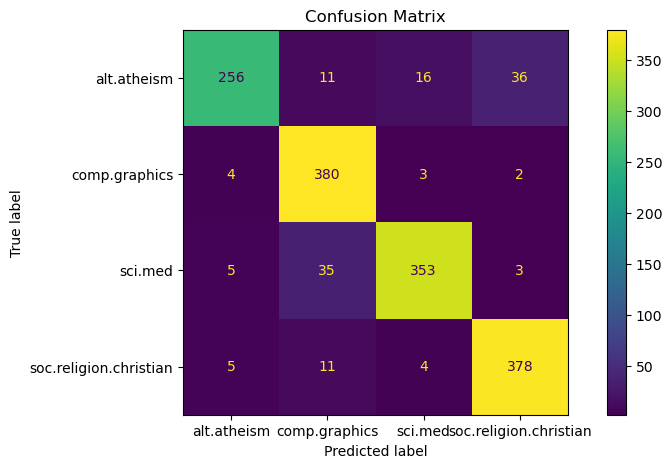

In [64]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(twenty_test.target, predicted, ax=ax)
ax.xaxis.set_ticklabels(twenty_train.target_names)
ax.yaxis.set_ticklabels(twenty_train.target_names)
_ = ax.set_title(
    f"Confusion Matrix"
)